# Assignment 6 - Object recognition in images with deep learning

## Goals

In this assignment you will get to know the main ingredients of deep learning and get to use the GPUs available in the Big Data Lab.

You'll learn to use

 * tensors and automatic differentiation
 * layered models
 * p(re)trained networks for image classification.

## Check the GPU setup

When you are logged in to a lab machine, run ``nvidia-smi`` to see the available card and its memory usage.

```
$ nvidia-smi
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  Off  | 00000000:01:00.0  On |                  N/A |
| 45%   24C    P8    N/A /  75W |   3087MiB /  4038MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU       PID   Type   Process name                             Usage      |
|=============================================================================|
|    0      3627      G   /usr/lib/xorg/Xorg                           169MiB |
|    0     10843      C   ...d/CMPT/big-data/tmp_py/dlenv/bin/python  2897MiB |
+-----------------------------------------------------------------------------+
```

This shows that the machine has an **NVIDIA GTX 1050 with 4G of RAM**. Also, you can see that it is running a process (pid=10843) that currently takes up close to 3 GB of GPU memory. On our current `blu9402` lab machines you will notice a difference, as they have 8GB of RAM.

```
$ pstree -ls 10843
screen───bash───jupyter-noteboo───python─┬─4*[python]
                                         └─26*[{python}]
```
Inside a terminal window you may use ``who``, ``ps -aux | less``, or ``pstree -ls <PID>`` as above to find out who is using the shared resources. In my case, it turns out that I'm running a jupyter notebook related to process 10843. Halting the notebook frees up the GPU memory.

## PyTorch setup in the lab

To build deep learning models in this assignment we are using **[PyTorch](http://pytorch.org)**, a replacement for numpy that provides accelerated computation on the GPU, automatic differentiation, and various utilities to train and deploy neural networks. Its popularity relative to [tensorflow](http://tensorflow.org) has been steadily increasing and it also has a high-level API, the [NN module](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) similar to [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras).

In case you have trouble configuring a conda environment that has a CUDA version of pytorch installed, you could use the one that's provided under the prefix  
`conda activate /usr/shared/CMPT/big-data/condaenv/nn11`

### Save disk space in the lab: Use shared downloaded pre-built models
To save disk space in your home folder, we recommend that you let pytorch use the pre-built models that we already downloaded for you (about 1.9G):
```
mkdir -p ~/.cache/torch/hub/checkpoints
ln -s /usr/shared/CMPT/big-data/dot_torch_shared/checkpoints/* ~/.cache/torch/hub/checkpoints
```

## Learn about Pytorch usage

To familiarize yourself with PyTorch, have a look at the [Examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html) on Tensors, or the NN module, or briefly skim over the [60 min blitz tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).

# Task 1: Finding rectangles

A nice [**blog-post** by Johannes Rieke](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491) presents a simple setup from scratch that finds rectangles in a black & white image. In order to play with it, we just have to translate a few calls from Keras to PyTorch.

To familiarize yourself with using pytorch, have a look at the [Examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html). The following code is preparing our training setup.

In [11]:
# to check GPU memory, uncomment and run the following line
!{'nvidia-smi'}

Sat Mar  2 02:41:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

The training data consists of $50,000$ example images.  
`imgs` is an array of shape (50000, 8, 8), giving an $8\times8$ pixel image for each example.  
`bboxes` is an array of shape (50000, 1, 4), giving a $1\times4$ row vector [x, y, w, h] for each rectangle.

**Here is an example of the training data:**

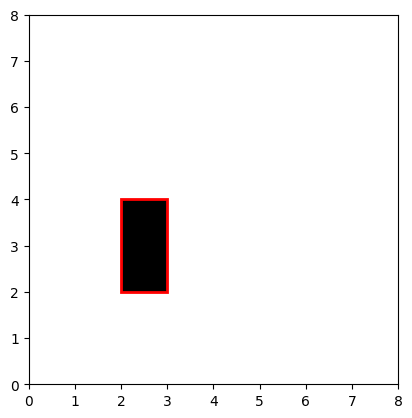

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, Markdown

# Create images with random rectangles and bounding boxes.
num_imgs = 50000

img_size = 8
min_object_size = 1
max_object_size = 4
num_objects = 1

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))  # set background to 0

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.  # set rectangle to 1
        bboxes[i_img, i_object] = [x, y, w, h]

display(Markdown(f"The training data consists of ${num_imgs:,}$ example images.  \n"
                 f"`imgs` is an array of shape {imgs.shape}, giving an ${img_size}\\times{img_size}$ pixel image for each example.  \n"
                 f"`bboxes` is an array of shape {bboxes.shape}, giving a $1\\times4$ row vector [x, y, w, h] for each rectangle."
                ))
display(Markdown('**Here is an example of the training data:**'))
i = 0
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none', lw=2))

In [5]:
# Reshape and normalize the image data to mean 0 and std 1.
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
display(Markdown(f"New shape of `imgs`: {X.shape}, with normalized mean {np.mean(X):.2f} and stdev {np.std(X):.2f}"))

# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

# Split training and test.
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

New shape of `imgs`: (50000, 64), with normalized mean -0.00 and stdev 1.00

## Task 1a
**Construct a Pytorch model that resembles the Keras one in the original blog post**, i.e. have a fully connected, hidden layer with 200 neurons, ReLU nonlinearity and dropout rate of 20%.

In [6]:
model = nn.Sequential(
            nn.Linear(64, 200),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(200, 4))

In [7]:
optimizer = torch.optim.Adadelta(model.parameters())
loss_fn = torch.nn.MSELoss(size_average=False)

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [8]:
inputs = Variable(torch.Tensor(train_X))
labels = Variable(torch.Tensor(train_y))

In [9]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Move model to the device
# model.to(device)

# # Move inputs and labels to the device
# inputs = inputs.to(device)
# labels = labels.to(device)


phase = 'train'
model.train()
do_test_loss = False

loss_record = []
loss_test_record = []
for epoch in range(30):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss_record.append(loss.data.item())

    if phase == 'train':
        loss.backward()
        optimizer.step()

    if do_test_loss:
        outputs_test = model(inputs_test)
        loss_test = loss_fn(outputs_test, labels_test)
        loss_test_record.append(loss_test.data.item())


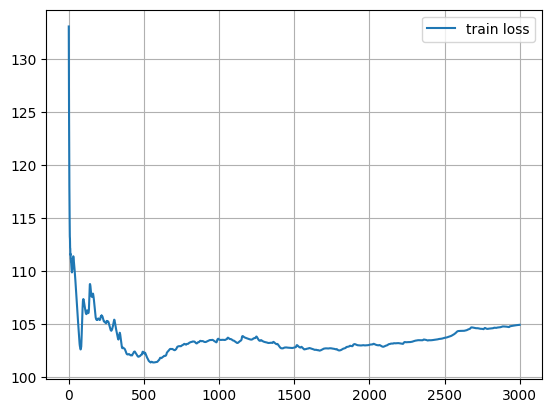

In [13]:
plt.plot(loss_record)
if do_test_loss:
    plt.plot(loss_test_record)
    plt.legend(["train loss", "test loss"])
else:
    plt.legend(["train loss"])
plt.grid(True)

**Change the model from training to evaluation mode** to improve testing performance.

In [1]:
phase = 'test'
# TODO
# ...


running_loss = 0.0
running_corrects = 0

loss_record = []
for epoch in range(3000):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    if phase == 'test':
        loss.backward()
        optimizer.step()
        model.eval()

    running_loss += loss.data * inputs.size(0)
    epoch_loss = running_loss / inputs.shape[0] / (epoch+1)
    loss_record.append(epoch_loss)

NameError: name 'optimizer' is not defined

In [ ]:
# Predict bounding boxes on the test images.

pred_y = model(Variable(torch.Tensor(test_X)))
pred_bboxes = pred_y.data * img_size
pred_bboxes = pred_bboxes.numpy().reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

In [ ]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    return I / U

0.31191300262456884

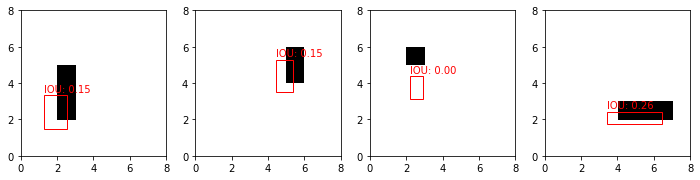

In [ ]:
# Show a few images and predicted bounding boxes from the test dataset.
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
# Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset.
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

## Task 1b:
Move the computation that is currently done on the CPU over to the GPU using CUDA and increase the number of epochs.  **Improve the training setup**, possibly also changing model or optimizer, until you **reach a test IOU above 0.9**.

You can make the changes that move computation to the GPU directly in the cells above as part of 1a.

You may get stuck not achieving test IOU above 0.6. In that case, learn about switching the model to evaluation mode and apply the change above.

## Question 1c:
Why does `eval` mode above have such a significant effect on test performance? Please give a short answer below.

# Task 2: Use a pretrained model

As mentioned in class, deep learning systems are hardly ever developed from scratch, but usually work by refining existing solutions to similar problems. For the following task, we'll **work through the
[Transfer learning tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)**, which also provides a ready-made jupyter notebook.

 **2.1.** Download the notebook and get it to run in your environment. This also involves downloading the bees and ants dataset.  
 **2.2.** Perform your own training with the provided setup, fill out the answer to Task 2.2 below.  
 **2.3.** Change the currently chosen pretrained network (resnet) to a different one. At least try out VGG and one other type and use the "conv net as fixed feature extractor" approach, fill out the answer to Task 2.3 below.  
 **2.4.** Load a picture that you took yourself and classify it with an unmodified pretrained network (e.g. the original VGG network) that can detect one out of 1000 classes. Fill out the answer to Task 2.4 below.

## Your solution for Task 2

Before you start, get the data from [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) and extract it into a subfolder `data`. The following import is going to attempt loading the image data from there.

Initialize much of the source code from the tutorial notebook located at
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
using [this module](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A6/tfl_tut.py)

In [3]:
!unzip hymenoptera_data

Archive:  hymenoptera_data.zip
replace hymenoptera_data/train/ants/0013035.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/1473187633_63ccaacea6.jpg  

In [4]:
from tfl_tut import *

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Please study the original notebook and then continue to use its functions as imported from the `tfl_tut` model for convenience to minimize source code copy & paste.

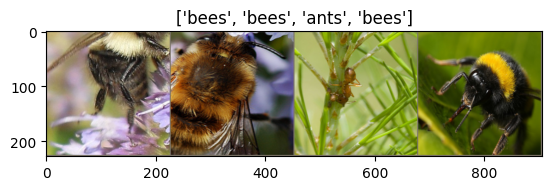

In [5]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
model_ft = models.inception_v3(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 162MB/s] 


### Answer for Task 2.2

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [9]:
# TODO paste and maybe modify relevant code to perform your own training

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft.aux_logits = False

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5572 Acc: 0.7131
val Loss: 0.2817 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.4103 Acc: 0.8279
val Loss: 0.2116 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.3610 Acc: 0.8402
val Loss: 0.2188 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.3783 Acc: 0.8238
val Loss: 0.1924 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.3886 Acc: 0.8361
val Loss: 0.3188 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.4302 Acc: 0.8279
val Loss: 0.2139 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.3992 Acc: 0.8361
val Loss: 0.2167 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3732 Acc: 0.8607
val Loss: 0.1994 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.2934 Acc: 0.8852
val Loss: 0.1954 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.2881 Acc: 0.8852
val Loss: 0.1726 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3009 Acc: 0.8811
val Loss: 0.1861 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.2707 Acc: 0.8689
val Loss: 0.1628 Acc: 0.9216

Ep

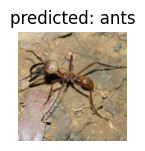

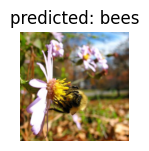

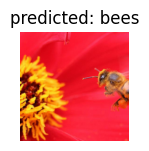

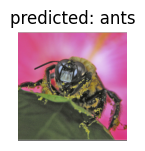

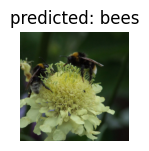

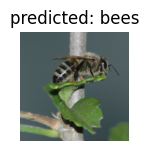

In [10]:
visualize_model(model_ft)

### Answer for Task 2.3

### Hints for this task

Focus on the section **Conv net as fixed feature xtractor** of the transfer learning tutorial.
First, change the line
```
model_conv = models.resnet18(pretrained=True)
```
to load VGG16 instead. Set all its parameters to *not* require gradient computation, as shown in the tutorial.

Next, print out the new `model_conv` and identify the last step of the classification. This is not named the same way as the ```fc``` layer for resnet, but it works similarily. The last classification step of the VGG model determines the probabilities for each of the 1000 classes of the dataset. Change this layer to identify only 2 classes to distinguish ants and bees as in the example.

To change the structure of some `Sequential` component called ```model_conv.module_name``` and to modify its last layer into a `DifferentLayer` type, you can use this syntax:

```
nn.Sequential(*list(model_conv.module_name.children())[:-1] +
                     [nn.DifferentLayer(...)])
```
and replace the old `model_conv.module_name` with this differently structured version.

In [11]:
# TODO
model_conv = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
previos_in_feature = model_conv.classifier[-1].in_features

model_conv.classifier = nn.Sequential(*list(model_conv.classifier.children())[:-1] +
                     [nn.Linear(previos_in_feature,2)])

model_conv = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_conv.aux_logits = False

model_conv = train_model(model_conv, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


Epoch 0/24
----------
train Loss: 0.2895 Acc: 0.8893
val Loss: 0.1309 Acc: 0.9673

Epoch 1/24
----------
train Loss: 0.4728 Acc: 0.7664
val Loss: 0.3648 Acc: 0.8431

Epoch 2/24
----------
train Loss: 0.3855 Acc: 0.8361
val Loss: 0.3169 Acc: 0.8497

Epoch 3/24
----------
train Loss: 0.3473 Acc: 0.8525
val Loss: 0.2136 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.3492 Acc: 0.8607
val Loss: 0.2420 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.3441 Acc: 0.8566
val Loss: 0.1860 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.2217 Acc: 0.8893
val Loss: 0.2915 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.3204 Acc: 0.8975
val Loss: 0.1816 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3334 Acc: 0.8607
val Loss: 0.2279 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.1783 Acc: 0.9262
val Loss: 0.1670 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2809 Acc: 0.8893
val Loss: 0.1490 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3095 Acc: 0.8893
val Loss: 0.2073 Acc: 0.9150

Ep

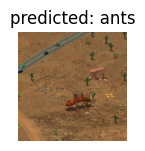

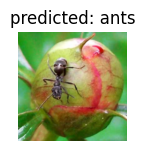

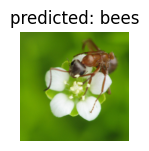

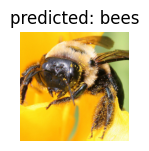

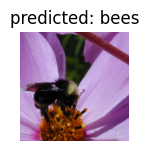

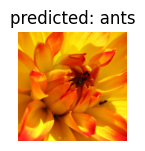

In [13]:
visualize_model(model_conv)

### Answer for Task 2.4

Predicted Image label: cock


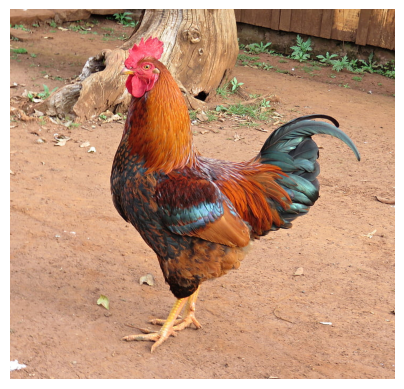

In [14]:

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import urllib
import matplotlib.pyplot as plt
import json

# Load the pretrained VGG model
vgg = models.vgg16(pretrained=True)
vgg.eval()

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
image = Image.open("my_image.jpg")
input_image = transform(image).unsqueeze(0)

# Perform inference
with torch.no_grad():
    outputs = vgg(input_image)
    _, preds = torch.max(outputs, 1)

# Load the classes
classes_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
with urllib.request.urlopen(classes_url) as url:
    classes = json.loads(url.read().decode())

label = classes[preds.item()]
print("Predicted Image label:", label)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()


Please include the picture so we can view it and its class label in the saved notebook. It's OK, if we don't have the actual image file to reproduce the output.

## Submission

Your submission should be based on a modified version of [this notebook](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A6/A6.ipynb) containing answers to Task 1 and for Task 2, saved with figures including some portions of the transfer learning tutorial notebook in the sections for tasks 2.1 - 2.4.